## Traitement de données de la LNH à partir classificateurs linéaire

Dans ce projet, il s'agissait de tester la capacité de différents classificateurs linéaires à prédire certaines données intéressantes. Le but ici était de savoir si, à partir de données facilement accessibles (temps de glace, position, tirs au but, etc.) il était possible de prédire les différents indices de production offensive d'un joueur de la LNH.

Différents modèles ont d'abord été explorés, puis une sélection de variables a été tentée à l'aide de la méthode dite de "Bolasso". Les modèles ont ensuité été réentraînés avec les variables sélectionnées pour voir quelle serait la variation de perte de nos prédicateurs.

Les modèles ont été produits à l'aide de la bibliothèque Scikit-Learn.

In [1]:
import pandas
import numpy as np

In [2]:
raw = pandas.read_excel('filtered_data.xlsx')
raw.columns
#len(raw.columns)

Index(['Last Name', 'First Name', 'Position', 'GP', 'G', 'A', 'A1', 'PTS',
       '+/-', 'IPP%', 'TOI/GP', 'iCF', 'iFF', 'iSF', 'iSCF', 'iHDCF', 'iRush',
       'iReb', 'Pass', 'ZS%', 'iGVA', 'iTKA', 'iBLK', 'S.Bkhd', 'S.Dflct',
       'S.Slap', 'S.Snap', 'S.Tip', 'S.Wrap', 'S.Wrst', 'CF', 'CA', 'FF', 'FA',
       'SF', 'SA', 'Ht', 'Wt', 'Age', 'PIM'],
      dtype='object')

In [3]:
player_names = raw['First Name'].values + ' ' + raw['Last Name'].values
raw = raw.drop(columns=['First Name', 'Last Name'])

targets_goals = raw['G'].values.reshape(-1,1).astype(dtype = 'float32')
targets_assists = raw['A'].values.reshape(-1,1).astype(dtype = 'float32')
targets_primary_assists = raw['A1'].values.reshape(-1,1).astype(dtype = 'float32')
targets_points = raw['PTS'].values.reshape(-1,1).astype(dtype = 'float32')
targets_plusminus = raw['+/-'].values.reshape(-1,1).astype(dtype = 'float32')
raw = raw.drop(columns = ['G', 'A', 'A1','PTS', '+/-'])

In [4]:
for i,position in enumerate(raw['Position']):
    if position in ['C/RW', 'LW/C', 'LW/RW', 'RW/C', 'LW', 'RW']:
        raw['Position'][i] = 'W'
one_hot_position = pandas.get_dummies(raw['Position'])
raw = raw.drop(columns = ['Position'])

C:\Users\Simon\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [5]:
def shuffle_data(*sets):
    rng_state = np.random.get_state()
    for set in sets:
        np.random.set_state(rng_state)
        np.random.shuffle(set)

In [6]:
data = np.concatenate((one_hot_position, raw.values), axis=1).astype(dtype = 'float32')
xdata=np.array(data)
shuffle_data(player_names, targets_goals, targets_assists, targets_primary_assists, targets_plusminus, targets_points, data)

In [7]:
train_size = int(data.shape[0] * 0.70)
valid_size = int(data.shape[0] * 0.10)
split = np.array([train_size+valid_size])

In [8]:
#Separate training and test sets
training_player_names, test_player_names = np.split(player_names, split)
training_targets_goal, test_targets_goals = np.split(targets_goals, split)
training_targets_assists, test_targets_assists = np.split(targets_assists, split)
training_targets_primary_assists, test_targets_primary_assists = np.split(targets_primary_assists, split)
training_targets_plusminus, test_targets_plusminus = np.split(targets_plusminus, split)
training_targets_points, test_targets_points = np.split(targets_points, split)
training_data, test_data = np.split(data, split)

In [9]:
print(training_data.shape)

(712, 35)


## Implémentation Random Forest et Baye's Ridge

In [10]:
# vérifier que sklearn est bien installé en exécutant cette cellule
import sklearn
import matplotlib.pyplot as plt

In [11]:
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.svm import LinearSVR,SVR

In [12]:
classifiers = [
    ('Random Forests', RandomForestRegressor()),
    ("Bayesian Ridge Regression",BayesianRidge()),
    ("Support Vector Regression",LinearSVR(dual=False,loss="squared_epsilon_insensitive"))
]

to_predict = [
    (training_targets_goal, test_targets_goals,"Goals"),
    (training_targets_assists, test_targets_assists,"Assists"),
    (training_targets_primary_assists, test_targets_primary_assists,"Primary Assists"),
    (training_targets_plusminus, test_targets_plusminus,"Plus/Minus"),
    (training_targets_points, test_targets_points,"Points")
]

C:\Users\Simon\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


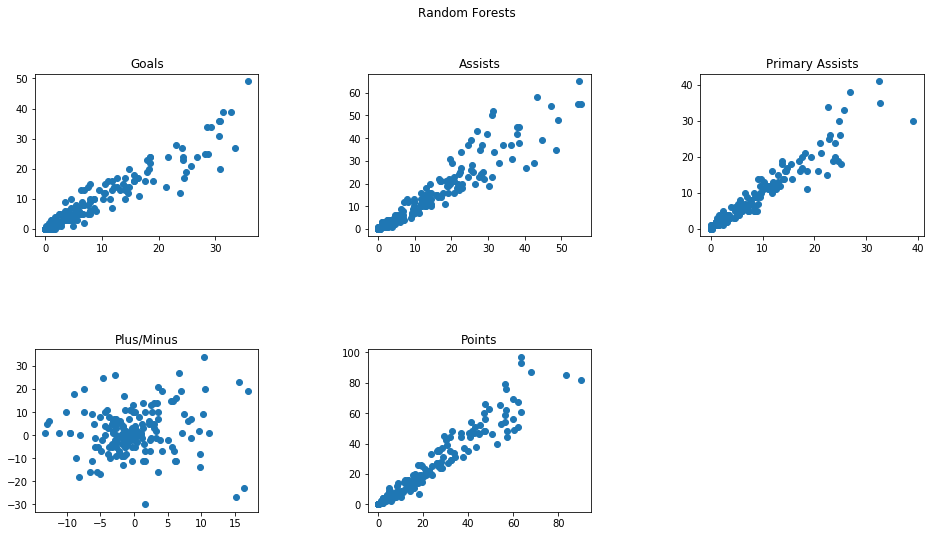

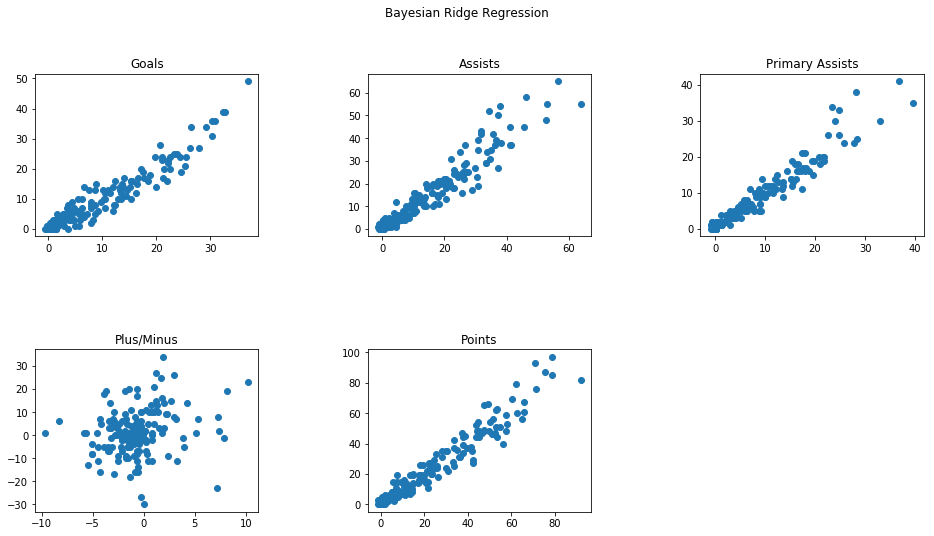

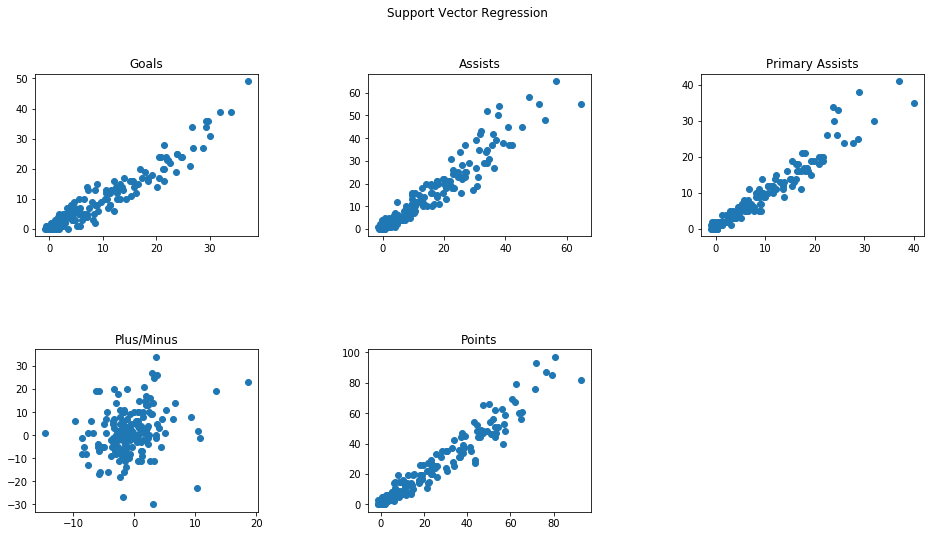

In [13]:
figure=0
for model_name, model_instance in classifiers:
    figure += 1
    plt.figure(figure,figsize=(15,20))
    plt.suptitle(model_name)
    i=0
    for target,to_print,name in to_predict:
        i+=1
        classifier = model_instance
        classifier.fit(training_data, target.ravel())
        
        plt.subplot(5,3,i)
        plt.scatter(classifier.predict(test_data),to_print)
        plt.title(name)
        
    plt.tight_layout(pad=8)
    plt.show()

## Exploring different kernels with SVR:

In [14]:
SVR_classifiers=[
    ("Linear SVR C=1", LinearSVR(dual=False,loss="squared_epsilon_insensitive")),
    ("Linear SVR C=100", LinearSVR(dual=False,loss="squared_epsilon_insensitive")),
    ("Basic case",LinearSVR(max_iter=20000))
#    ("RBF SVR", SVR(kernel="rbf",tol=1e-4,gamma='auto'))     stupid
]

Linear SVR C=1-->Goals
Linear SVR C=1-->Assists
Linear SVR C=1-->Primary Assists
Linear SVR C=1-->Plus/Minus
Linear SVR C=1-->Points
Linear SVR C=100-->Goals
Linear SVR C=100-->Assists
Linear SVR C=100-->Primary Assists
Linear SVR C=100-->Plus/Minus
Linear SVR C=100-->Points


C:\Users\Simon\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Basic case-->Goals


C:\Users\Simon\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Basic case-->Assists


C:\Users\Simon\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Basic case-->Primary Assists


C:\Users\Simon\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Basic case-->Plus/Minus
Basic case-->Points


C:\Users\Simon\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


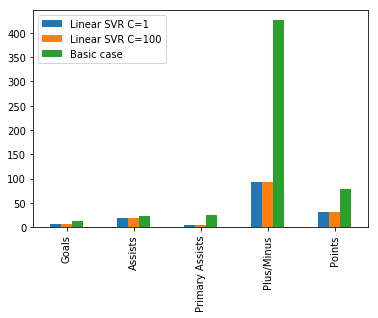

In [15]:
Lin_svr_err1=[]
Lin_svr_err2=[]
Lin_svr_err3=[]
#Rbf_svr_err=[]

sq_Err=[ Lin_svr_err1,Lin_svr_err2,Lin_svr_err3]
models=[]

for (model_name, model_instance),error in zip(SVR_classifiers,sq_Err):
    models.append(model_name)
    for target, to_print, target_name in to_predict:
        classifier = model_instance
        classifier.fit(training_data, target.ravel())

        sqr_error = sklearn.metrics.mean_squared_error(to_print,classifier.predict(test_data))
        error.append(sqr_error)
        print(model_name+'-->'+target_name)
bins=[]
for i,j,name in to_predict:
    bins.append(name)
#_X=np.arange(len(bins))
    
#for to_plot,(model_name,dummy) in zip(sq_Err,SVR_classifiers):
#    plt.bar(bins,to_plot,label=model_name)
   
df = pandas.DataFrame(np.c_[Lin_svr_err1,Lin_svr_err2,Lin_svr_err3],index=bins)
df=df.rename(index=str,columns={i:j for i,j in zip(range(3),models)})
df.plot.bar()
    
#plt.legend()
plt.show()

## Exploring different kind of Random Forests and tuning.

In [16]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error

In [29]:
Forest_regressors=[
    ('Random Forests', RandomForestRegressor()),
    ("Extra Trees", ExtraTreesRegressor())
]

tuned_parameters ={"n_estimators":[5,10,25,50,75,100,150],"max_features":[6,12,18,24,30,35],'min_samples_split':[i/100 for i in range(1,9)],'bootstrap':[True,False]}

for model_name,model in Forest_regressors:
    print("# Tuning hyper-parameters for: "+model_name)
    print()

    clf = GridSearchCV(model, tuned_parameters, cv=None)
    clf.fit(training_data, training_targets_goal.ravel())

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Calculating mean squared error on test set with best params found")
    print()
    y_true, y_pred = test_targets_goals, clf.predict(test_data)
    print("Erreur quadratique moyenne: ", mean_squared_error(y_true, y_pred))
    print()

# Tuning hyper-parameters for: Random Forests



C:\Users\Simon\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Best parameters set found on development set:

{'bootstrap': True, 'max_features': 24, 'min_samples_split': 0.02, 'n_estimators': 50}

Grid scores on development set:

0.838 (+/-0.024) for {'bootstrap': True, 'max_features': 6, 'min_samples_split': 0.01, 'n_estimators': 5}
0.855 (+/-0.026) for {'bootstrap': True, 'max_features': 6, 'min_samples_split': 0.01, 'n_estimators': 10}
0.862 (+/-0.029) for {'bootstrap': True, 'max_features': 6, 'min_samples_split': 0.01, 'n_estimators': 25}
0.864 (+/-0.020) for {'bootstrap': True, 'max_features': 6, 'min_samples_split': 0.01, 'n_estimators': 50}
0.862 (+/-0.023) for {'bootstrap': True, 'max_features': 6, 'min_samples_split': 0.01, 'n_estimators': 75}
0.866 (+/-0.024) for {'bootstrap': True, 'max_features': 6, 'min_samples_split': 0.01, 'n_estimators': 100}
0.862 (+/-0.022) for {'bootstrap': True, 'max_features': 6, 'min_samples_split': 0.01, 'n_estimators': 150}
0.855 (+/-0.047) for {'bootstrap': True, 'max_features': 6, 'min_samples_split': 0

C:\Users\Simon\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Best parameters set found on development set:

{'bootstrap': True, 'max_features': 35, 'min_samples_split': 0.05, 'n_estimators': 75}

Grid scores on development set:

0.824 (+/-0.032) for {'bootstrap': True, 'max_features': 6, 'min_samples_split': 0.01, 'n_estimators': 5}
0.851 (+/-0.031) for {'bootstrap': True, 'max_features': 6, 'min_samples_split': 0.01, 'n_estimators': 10}
0.850 (+/-0.024) for {'bootstrap': True, 'max_features': 6, 'min_samples_split': 0.01, 'n_estimators': 25}
0.857 (+/-0.024) for {'bootstrap': True, 'max_features': 6, 'min_samples_split': 0.01, 'n_estimators': 50}
0.862 (+/-0.021) for {'bootstrap': True, 'max_features': 6, 'min_samples_split': 0.01, 'n_estimators': 75}
0.862 (+/-0.024) for {'bootstrap': True, 'max_features': 6, 'min_samples_split': 0.01, 'n_estimators': 100}
0.864 (+/-0.021) for {'bootstrap': True, 'max_features': 6, 'min_samples_split': 0.01, 'n_estimators': 150}
0.836 (+/-0.014) for {'bootstrap': True, 'max_features': 6, 'min_samples_split': 0

In [ ]:
##Exploring different hyper-parameters for Bayesian Ridge Regression.
B_Ridge_regressors=[
    ('Bayesian Ridge Regressor', BayesianRidge())
]

tuned_parameters ={'alpha_1':[1e-7,5.5e-7,1e-6,5.5e-6,1e-5,5.5e-5],'alpha_2':[1e-7,5.5e-7,1e-6,5.5e-6,1e-5,5.5e-5],
                   'lambda_1':[1e-7,5.5e-7,1e-6,5.5e-6,1e-5,5.5e-5],'lambda_2':[1e-7,5.5e-7,1e-6,5.5e-6,1e-5,5.5e-5]}

for model_name,model in B_Ridge_regressors:
    print("# Tuning hyper-parameters for: "+model_name)
    print()

    clf = GridSearchCV(model, tuned_parameters, cv=None)
    clf.fit(training_data, training_targets_goal.ravel())

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Calculating mean squared error on test set with best params found")
    print()
    y_true, y_pred = test_targets_goals, clf.predict(test_data)
    print("Erreur quadratique moyenne: ", mean_squared_error(y_true, y_pred))
    print()

Le résultat de cette exploration n'est pas surprenant puisque les paramètres alpha et lambda sont des priors sur les distributions gammas qui servent à optimiser les paramètres. Il y a donc une convergence claire du modèle ici vers des alpha et lambda "optimaux".

## Exploring Basic Ridge Regression

In [19]:
##Exploring different hyper-parameters for Basic Ridge Regression.
#On fait cette exploration ici, mais on s'attend à ce qu'elle performe moins que le Bayesian Ridge Regression

from sklearn.linear_model import Ridge

Base_Ridge_regressors=[
    ('Basic Ridge Regressor', Ridge())
]

tuned_parameters ={'alpha':[1e-4,5e-4,1e-3,5e-3,1e-2,5e-2,1e-1,5e-1,1,5,1e1,5e1,1e2,5e2,1e3,5e3,1e4]}

for model_name,model in Base_Ridge_regressors:
    print("# Tuning hyper-parameters for: "+model_name)
    print()

    clf = GridSearchCV(model, tuned_parameters, cv=None)
    clf.fit(training_data, training_targets_goal.ravel())

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Calculating mean squared error on test set with best params found")
    print()
    y_true, y_pred = test_targets_goals, clf.predict(test_data)
    print("Erreur quadratique moyenne: ", mean_squared_error(y_true, y_pred))
    print()

# Tuning hyper-parameters for: Basic Ridge Regressor



C:\Users\Simon\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Simon\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:125: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.458611e-13
  overwrite_a=True).T
C:\Users\Simon\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:125: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.699126e-13
  overwrite_a=True).T
C:\Users\Simon\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:125: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.602411e-13
 

Best parameters set found on development set:

{'alpha': 0.5}

Grid scores on development set:

0.864 (+/-0.027) for {'alpha': 0.0001}
0.864 (+/-0.027) for {'alpha': 0.0005}
0.864 (+/-0.027) for {'alpha': 0.001}
0.864 (+/-0.027) for {'alpha': 0.005}
0.864 (+/-0.027) for {'alpha': 0.01}
0.864 (+/-0.027) for {'alpha': 0.05}
0.864 (+/-0.027) for {'alpha': 0.1}
0.864 (+/-0.027) for {'alpha': 0.5}
0.864 (+/-0.027) for {'alpha': 1}
0.864 (+/-0.027) for {'alpha': 5}
0.863 (+/-0.028) for {'alpha': 10.0}
0.862 (+/-0.028) for {'alpha': 50.0}
0.862 (+/-0.028) for {'alpha': 100.0}
0.862 (+/-0.027) for {'alpha': 500.0}
0.862 (+/-0.026) for {'alpha': 1000.0}
0.861 (+/-0.023) for {'alpha': 5000.0}
0.861 (+/-0.023) for {'alpha': 10000.0}

Calculating mean squared error on test set with best params found

Erreur quadratique moyenne:  7.072707



## Keeping best params for retained models and plotting mean squared error on test set

Linear SVR-->Goals : 7.336926803353573
Linear SVR-->Assists : 18.350926993435863
Linear SVR-->Primary Assists : 4.5255618502228865
Linear SVR-->Plus/Minus : 93.73852383522497
Linear SVR-->Points : 31.522632115431325
Random Forests-->Goals : 10.010954592143856
Random Forests-->Assists : 18.95796291230744
Random Forests-->Primary Assists : 5.199583690920474
Random Forests-->Plus/Minus : 86.97225645831256
Random Forests-->Points : 36.23052102125397
Extra Trees-->Goals : 11.929912070774737
Extra Trees-->Assists : 20.14852199966455
Extra Trees-->Primary Assists : 5.1769759070533965
Extra Trees-->Plus/Minus : 92.34963564572033
Extra Trees-->Points : 34.07724573999143
Bayesian Ridge Regressor-->Goals : 7.587155939406192
Bayesian Ridge Regressor-->Assists : 18.1897129409551
Bayesian Ridge Regressor-->Primary Assists : 4.61985350925298
Bayesian Ridge Regressor-->Plus/Minus : 92.23528232409205
Bayesian Ridge Regressor-->Points : 32.2044166357919
Basic Ridge Regressor-->Goals : 7.2352858
Basic Ri

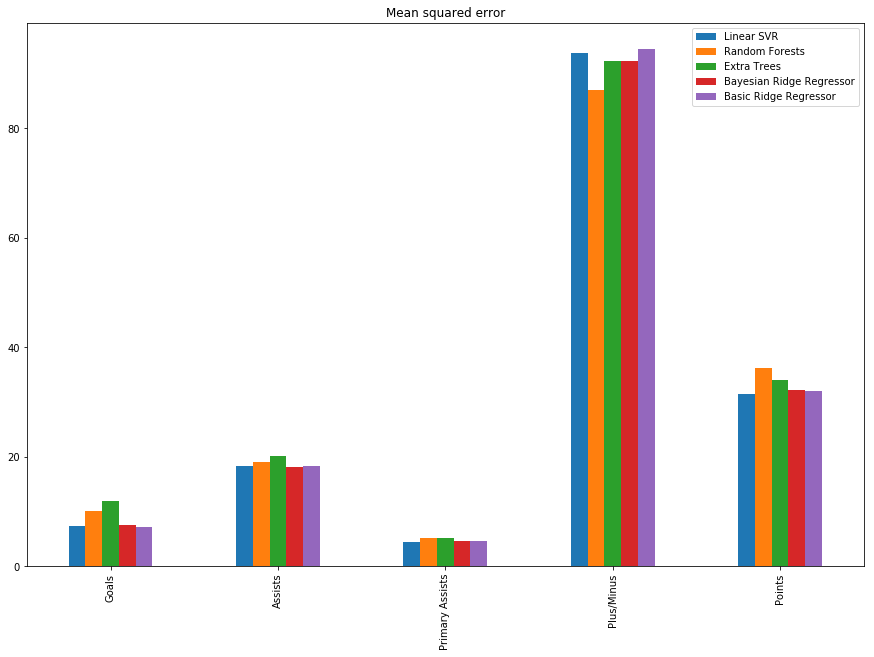

In [20]:
Retained_regressors=[
    ("Linear SVR", LinearSVR(dual=False,loss="squared_epsilon_insensitive")),
    ('Random Forests', RandomForestRegressor(bootstrap= True,max_features= 24,min_samples_split=0.02, n_estimators= 75)),
    ("Extra Trees", ExtraTreesRegressor(bootstrap= True, max_features= 35, min_samples_split=0.01, n_estimators= 25)),
    ('Bayesian Ridge Regressor', BayesianRidge()),
    ('Basic Ridge Regressor', Ridge(alpha= 1000.0))
    
]


Lin_r_err1,predict1=[],[]
Lin_r_err2,predict2=[],[]
Lin_r_err3,predict3=[],[]
Lin_r_err4,predict4=[],[]
Lin_r_err5,predict5=[],[]

sq_Err=[ Lin_r_err1,Lin_r_err2,Lin_r_err3,Lin_r_err4,Lin_r_err5]
all_predictions = [predict1,predict2,predict3,predict4,predict5]
models=[]

for (model_name, model_instance),error,predictions in zip(Retained_regressors,sq_Err,all_predictions):
    models.append(model_name)
    for target, to_print, target_name in to_predict:
        classifier = model_instance
        classifier.fit(training_data, target.ravel())

        sqr_error = sklearn.metrics.mean_squared_error(to_print,classifier.predict(test_data))
        error.append(sqr_error)
        predictions.append(classifier.predict(test_data))
        print(model_name+'-->'+target_name+' : '+str(sqr_error))
bins=[]
for i,j,name in to_predict:
    bins.append(name)
#_X=np.arange(len(bins))
    
#for to_plot,(model_name,dummy) in zip(sq_Err,SVR_classifiers):
#    plt.bar(bins,to_plot,label=model_name)


df = pandas.DataFrame(np.c_[Lin_r_err1,Lin_r_err2,Lin_r_err3,Lin_r_err4,Lin_r_err5],index=bins)
df=df.rename(index=str,columns={i:j for i,j in zip(range(5),models)})
df.plot.bar(figsize=(15,10))
    
#plt.legend()
plt.title("Mean squared error")
plt.show()

## Printing Deviations

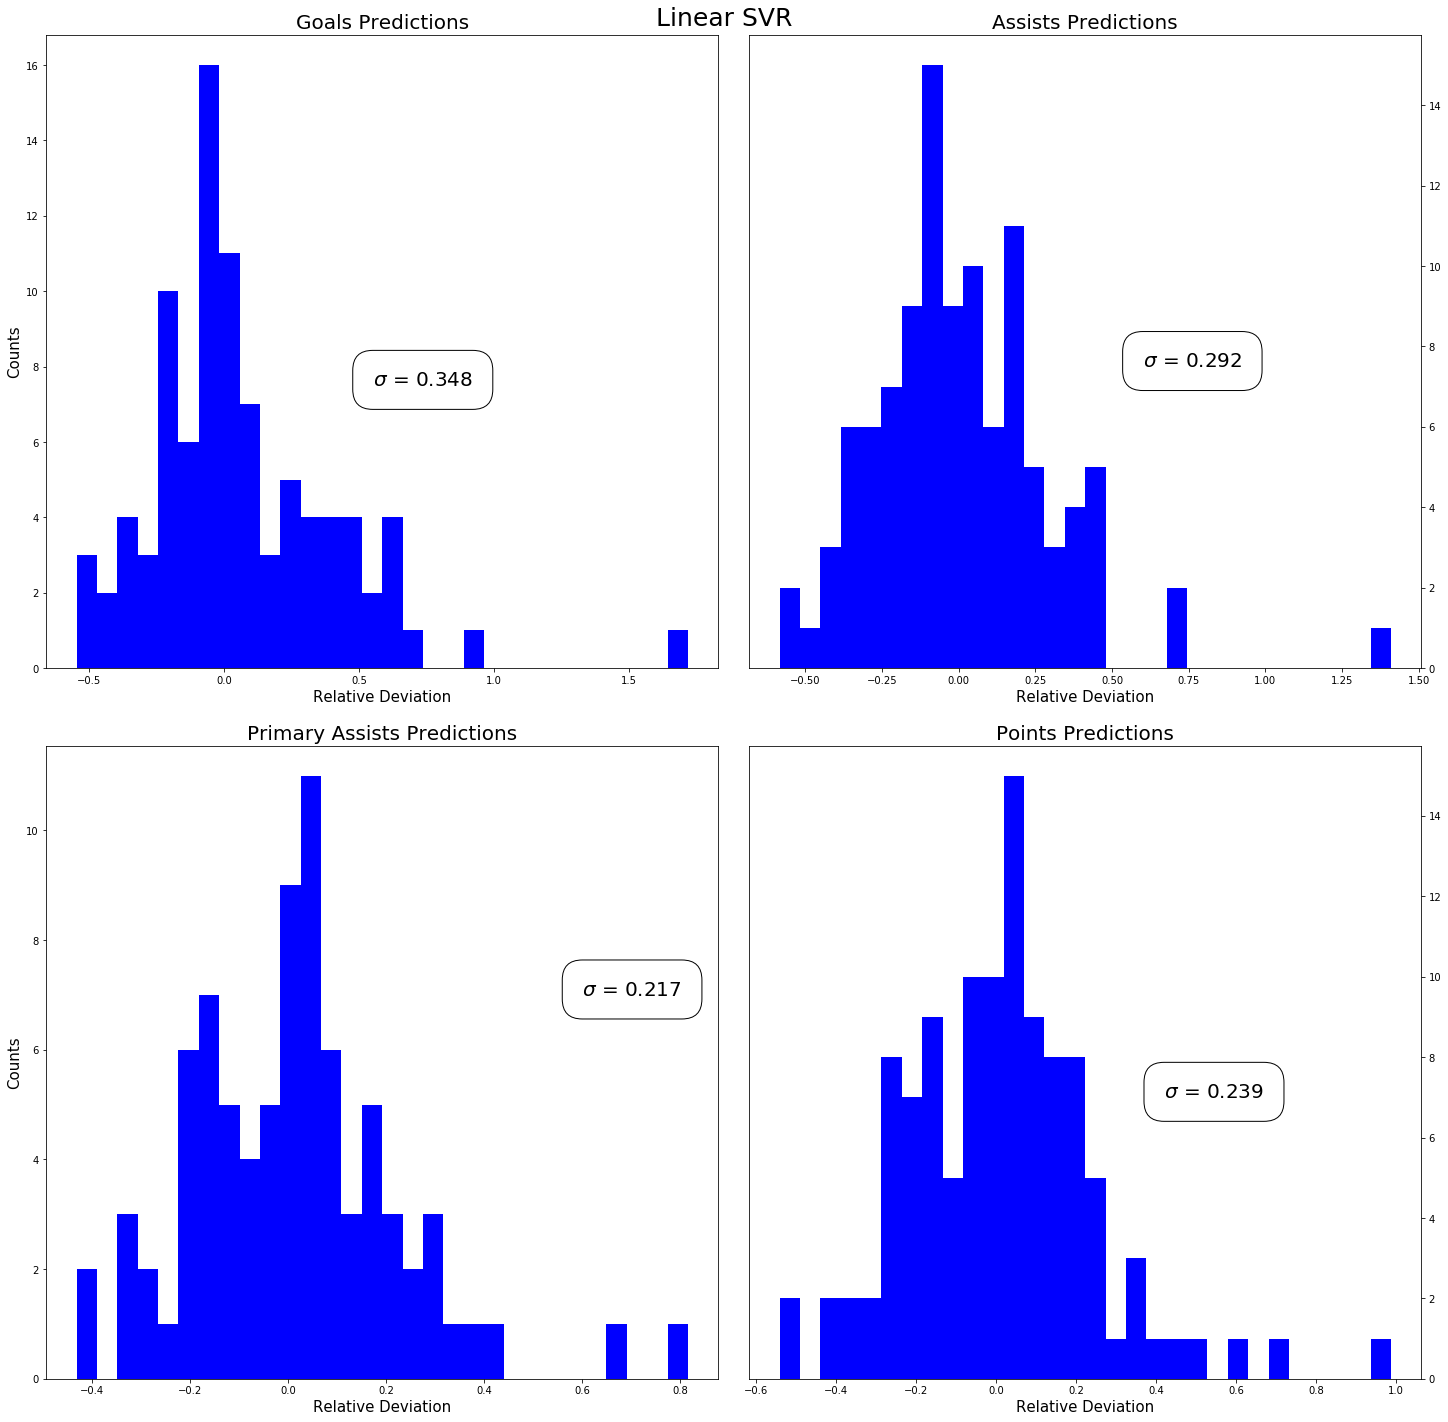

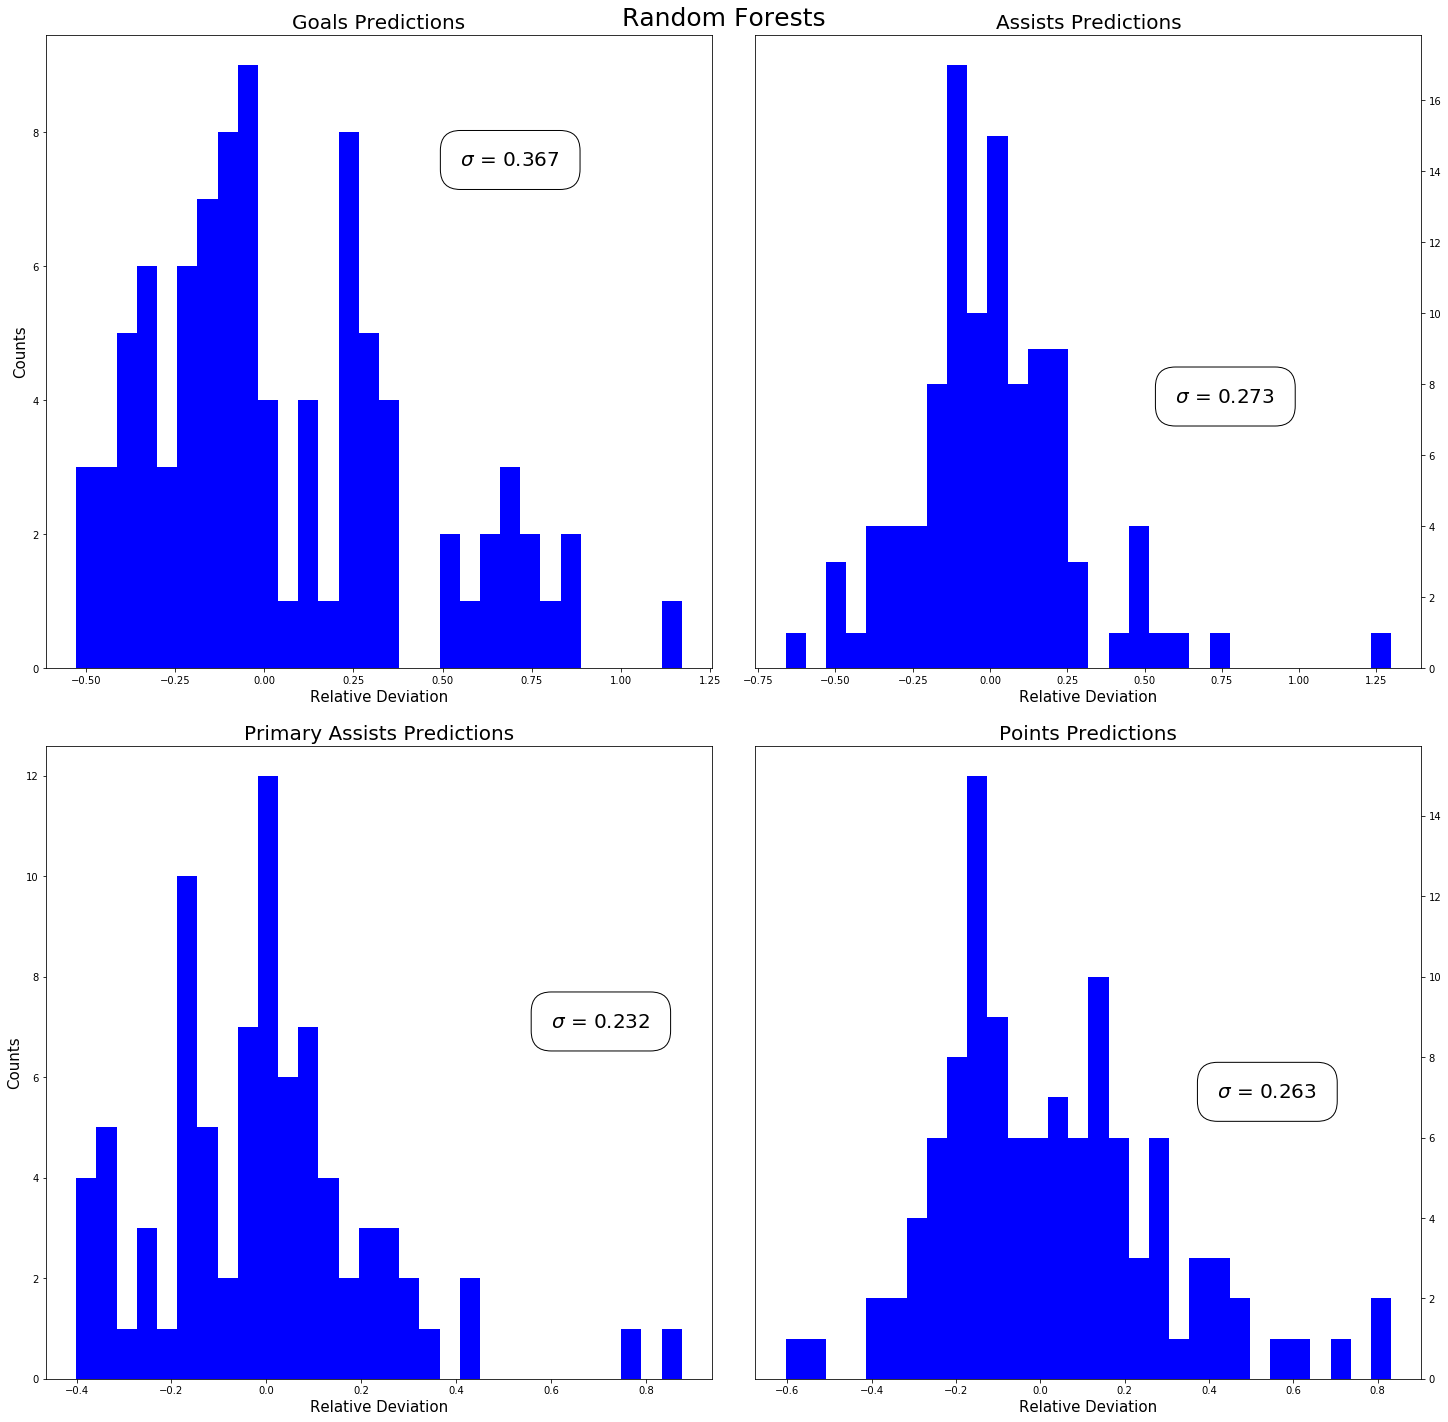

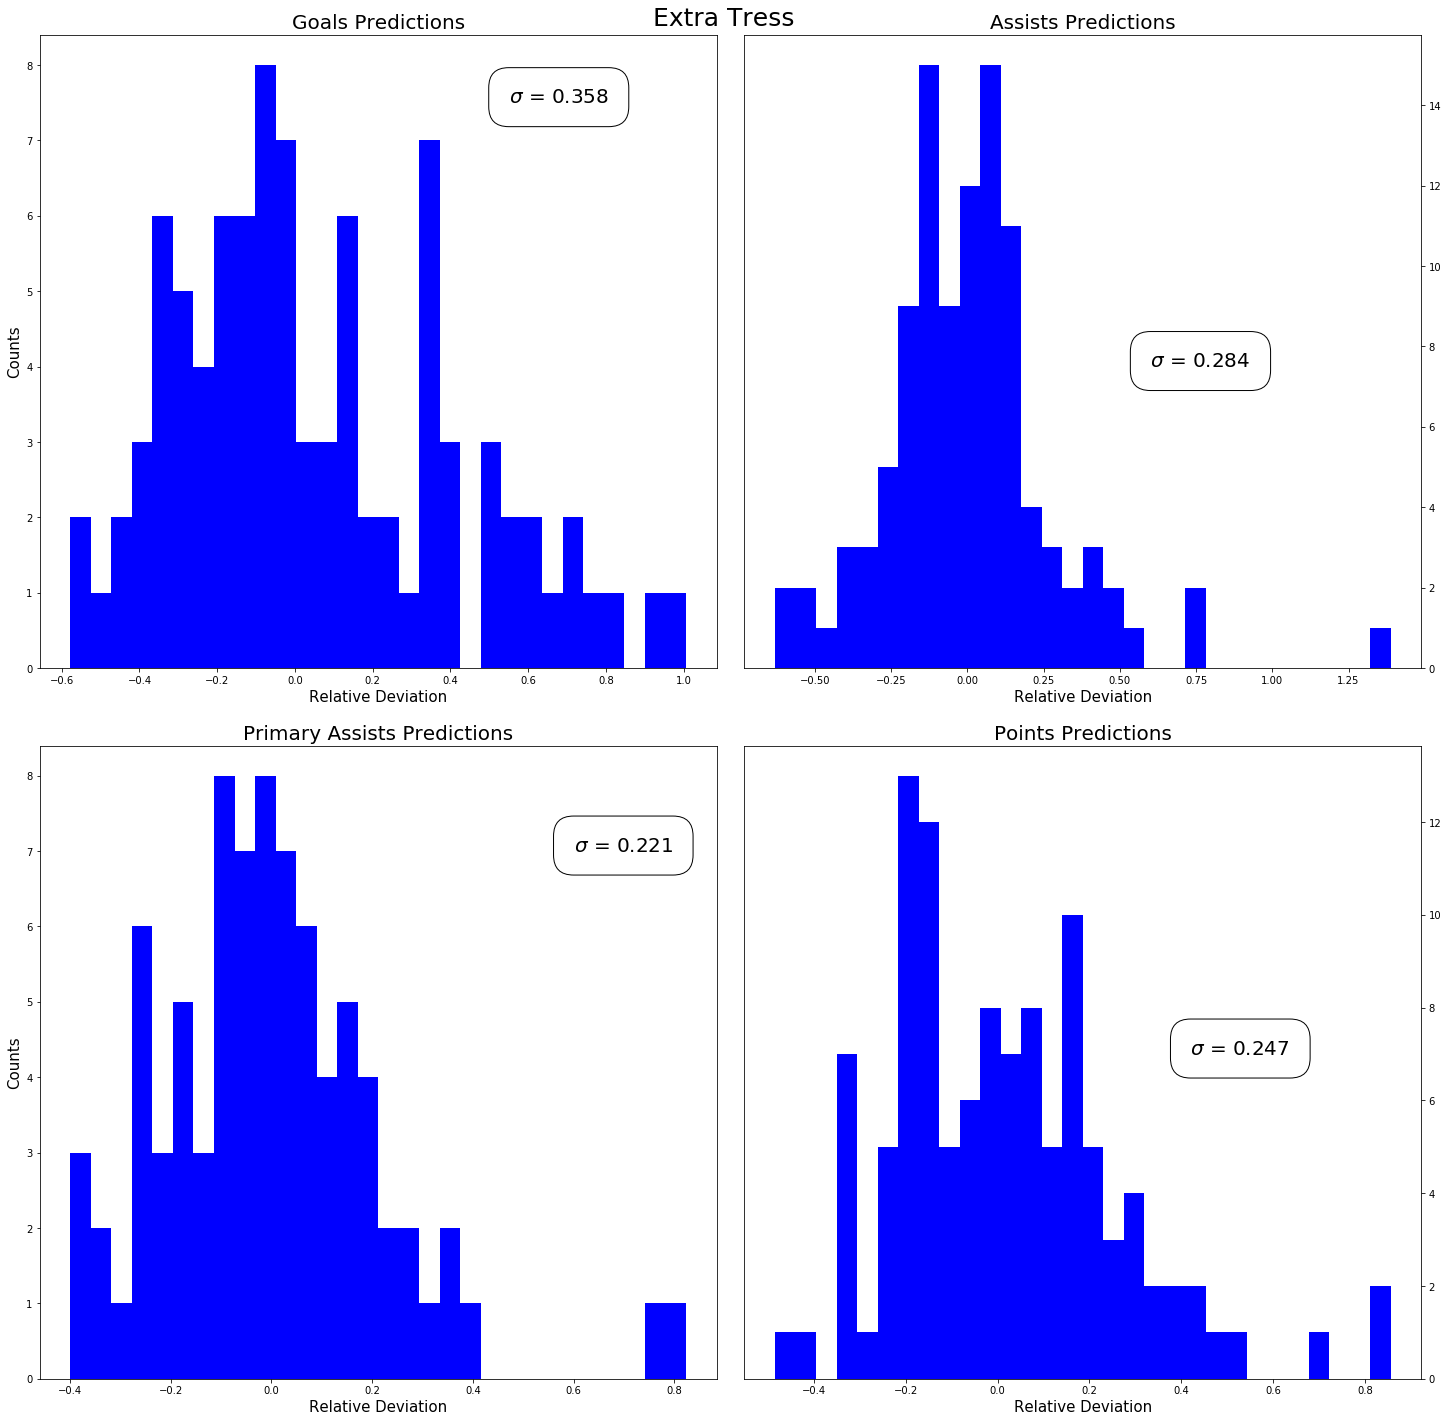

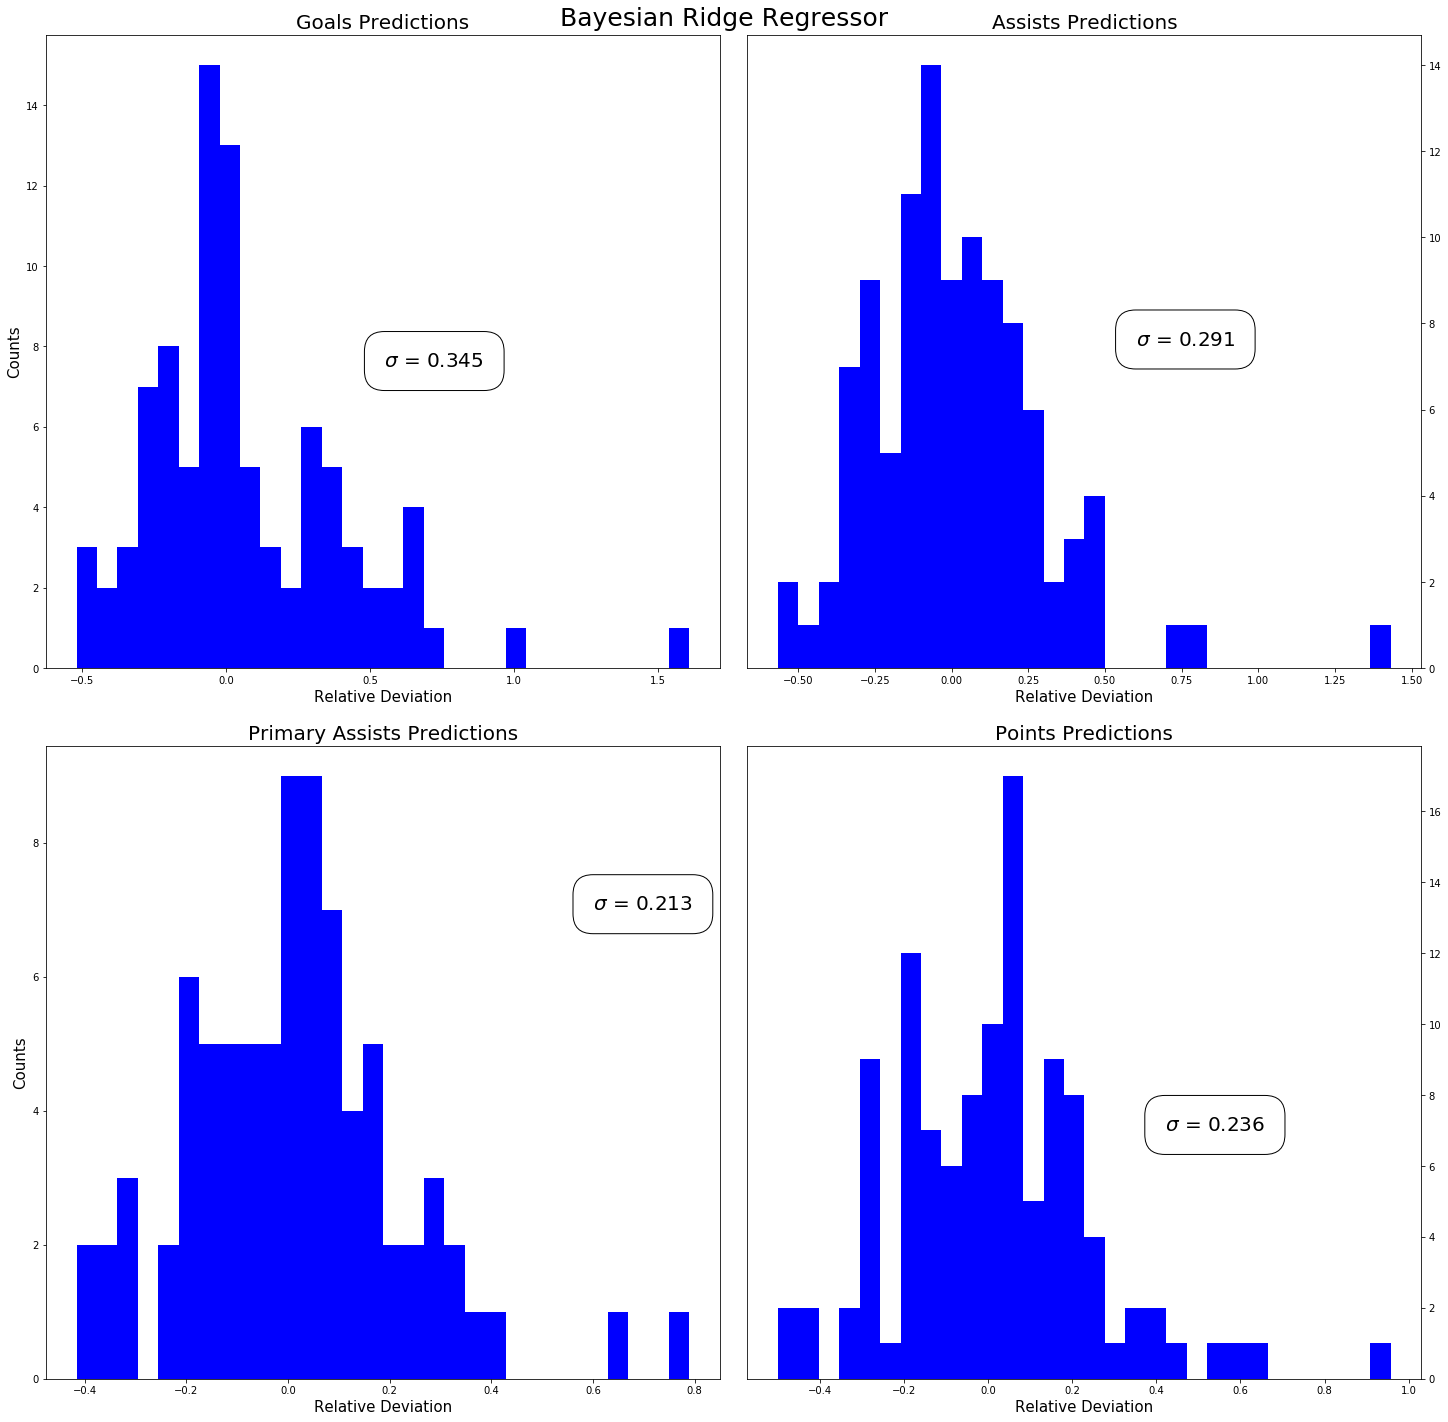

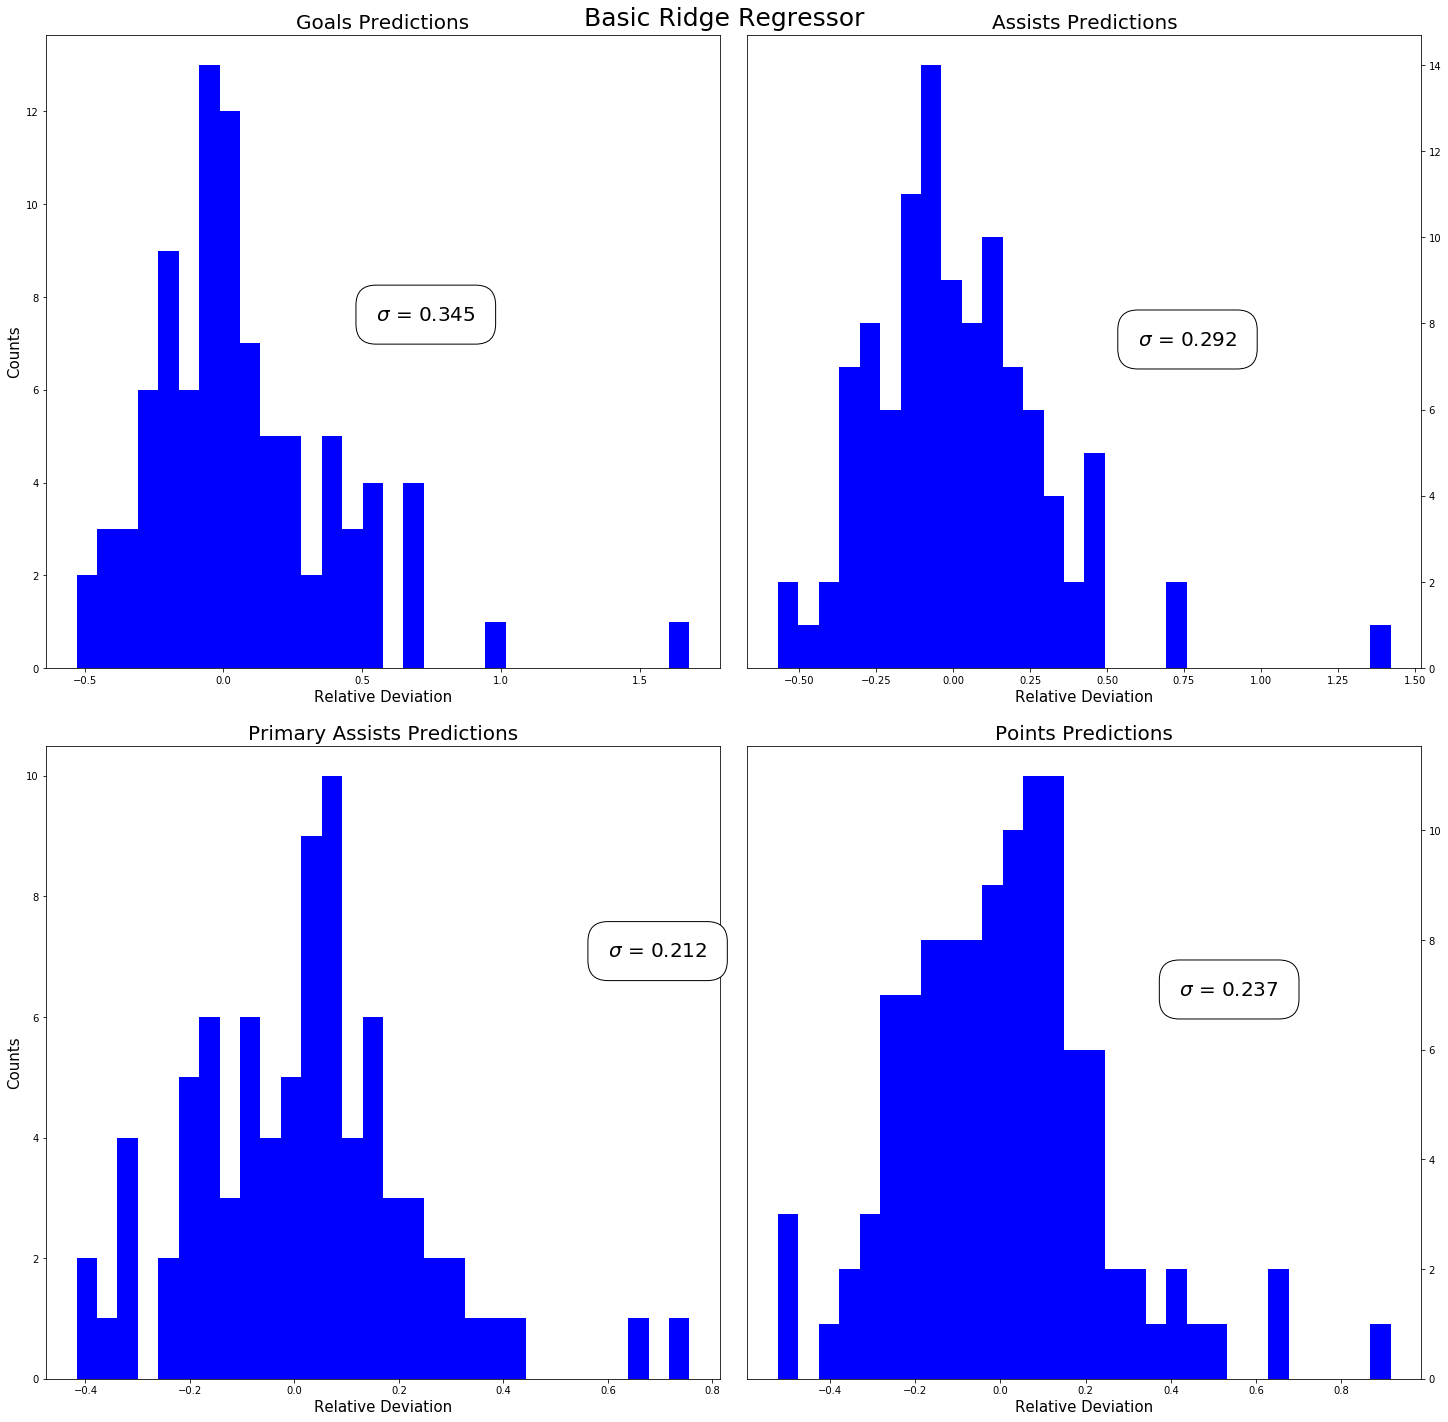

In [22]:

for (model_name,dummy),predictions_raw in zip(Retained_regressors,all_predictions):

    predictions = predictions_raw[:3]+predictions_raw[-1:]
    targets_list = [test_targets_goals, test_targets_assists, test_targets_primary_assists, test_targets_points]
    treshold_list = [5, 7, 5, 10]
    std, deviations = [], []
    for pred, target, treshold in zip(predictions, targets_list, treshold_list) :
        pred.shape=(len(pred),1)
        not_small = np.where(target > treshold)[0]
        deviations.append((pred[not_small] - target[not_small]) / target[not_small])
        std.append(np.std(deviations[-1]))

    fig, ax = plt.subplots(ncols=2, nrows=2, constrained_layout=True, figsize=(20,20))
    ax1, ax2, ax3, ax4 = ax.flatten()

    ax1.hist(deviations[0], bins=30,color='b')
    ax1.set_title('Goals Predictions', fontsize=20)
    ax1.set_xlabel('Relative Deviation', fontsize=15)
    ax1.set_ylabel('Counts', fontsize=15)
    ax1.text(0.55, 7.5, '$\sigma$ = {:5.3f}'.format(std[0]), color='black', 
            fontsize = 20, bbox=dict(facecolor='w', edgecolor='black', 
                      boxstyle='round,pad=1'))

    ax2.hist(deviations[1], bins=30,color='b')
    ax2.yaxis.tick_right()
    ax2.set_title('Assists Predictions', fontsize=20)
    ax2.set_xlabel('Relative Deviation', fontsize=15)
    ax2.text(0.6, 7.5, '$\sigma$ = {:5.3f}'.format(std[1]), color='black', 
            fontsize = 20, bbox=dict(facecolor='w', edgecolor='black', 
                      boxstyle='round,pad=1'))

    ax3.hist(deviations[2], bins=30,color='b')
    ax3.set_title('Primary Assists Predictions', fontsize=20)
    ax3.set_xlabel('Relative Deviation', fontsize=15)
    ax3.set_ylabel('Counts', fontsize=15)
    ax3.text(0.6, 7, '$\sigma$ = {:5.3f}'.format(std[2]), color='black', 
            fontsize = 20, bbox=dict(facecolor='w', edgecolor='black', 
                      boxstyle='round,pad=1'))

    ax4.hist(deviations[3], bins=30,color = 'b')
    ax4.yaxis.tick_right()
    ax4.set_title('Points Predictions', fontsize=20)
    ax4.set_xlabel('Relative Deviation', fontsize=15)
    ax4.text(0.42, 7, '$\sigma$ = {:5.3f}'.format(std[3]), color='black', 
            fontsize = 20, bbox=dict(facecolor='w', edgecolor='black', 
                      boxstyle='round,pad=1'))
    
    #plt.tight_layout()
    fig.suptitle(model_name,fontsize=25)
    plt.show()

------------------Goals---------------------------


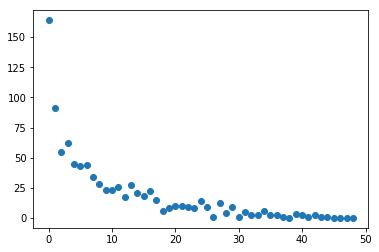

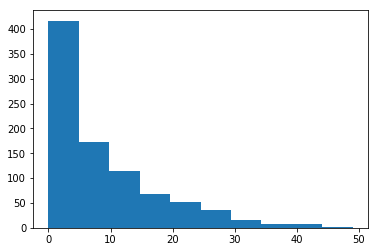

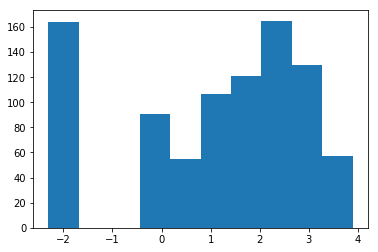

------------------Assists---------------------------


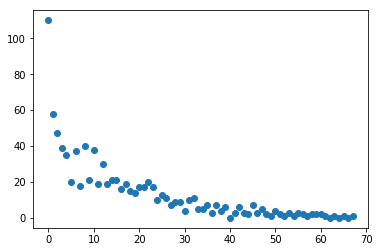

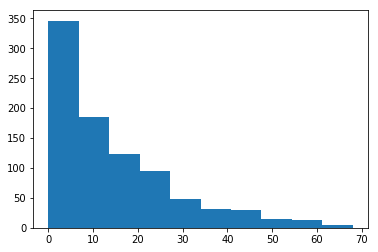

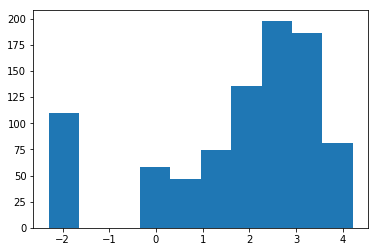

------------------Primary Assists---------------------------


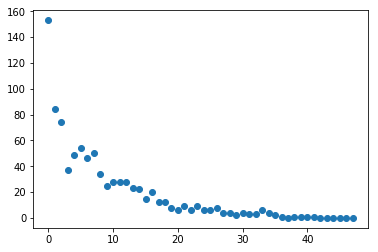

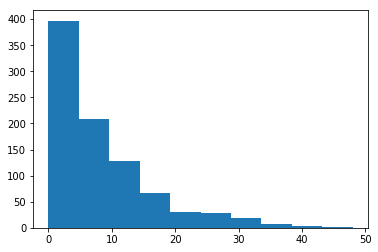

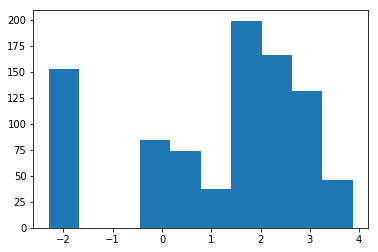

------------------Points---------------------------


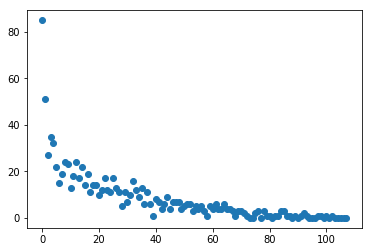

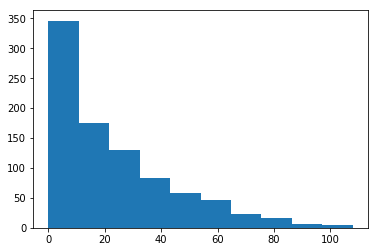

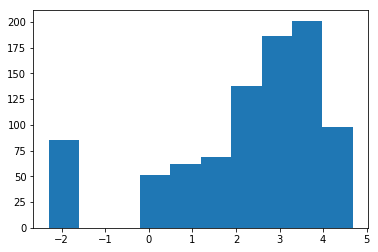

------------------Plus Minus---------------------------


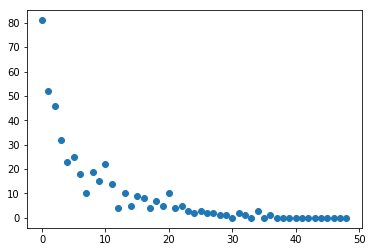

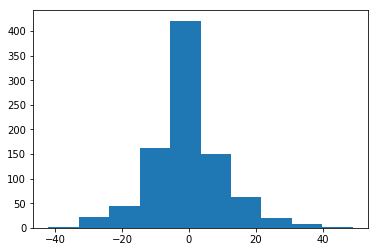

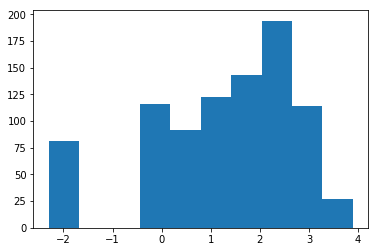

In [67]:
#print(targets_goals.shape)
#print(np.sum(targets_goals>13))

#goals
#assists
#prima

names=["Goals","Assists","Primary Assists","Points","Plus Minus"]
targets=[targets_goals,targets_assists,targets_primary_assists,targets_points,targets_plusminus]

for target,name in zip(targets,names):
    histo=[]
    for i in range(int(np.max(target))):
        histo.append(np.sum(target==i))

    print("------------------"+name+"---------------------------")    
    
    plt.scatter(range(int(np.max(target))),histo)
    plt.show()
    plt.hist(target)
    plt.show()
    epsilon = 1e-1
    plt.hist(np.log(np.abs(target)+epsilon))
    plt.show()




## Performing Variables Selection with Bolasso

The following section uses a modified version of the DSTK package developped by an MIT team and shared on github. In order to use it, make sure to have in working directory the DSTK folder included in the zip with the code. Running the code with the version on github will not work since it was developped for classification and we use it for regression.

In [13]:
from DSTK.BoostedFeatureSelectors import boselector as bs

In [53]:
import warnings
warnings.filterwarnings('ignore')

epsilon = 1e-1
dd = ['C','D','W']+list(raw.columns)
bolasso_training_data = pandas.DataFrame(data=training_data,columns=dd)

for targets,dummy,name in to_predict:

    bolasso_targets= pandas.DataFrame(data=targets.ravel())

    b = bs.Bolasso(bootstrap_fraction=0.8)
    b.fit(bolasso_training_data,bolasso_targets,epochs=10)
    
    print("------------------",name,'results---------------')
    display(b.get_feature_stats())
#    with pandas.option_context('display.max_rows', None, 'display.max_columns', None):
#        display(b.coeff_df)
    
    
    bolasso_targets= pandas.DataFrame(data=np.log(np.abs(targets).ravel()+epsilon))

    b = bs.Bolasso(bootstrap_fraction=0.8)
    b.fit(bolasso_training_data,bolasso_targets,epochs=10)
    
    print("-------------log of",name,'results---------------')
    display(b.get_feature_stats())
#    with pandas.option_context('display.max_rows', None, 'display.max_columns', None):
#        display(b.coeff_df)
    

>> Iteration: 10/10, elapsed time: 3.4 s
------------------ Goals results---------------


,coef_mean,coef_std,num_occurence,frac_occurence
PIM,-0.000950,0.0,10.0,1.0
CA,-0.002257,0.0,10.0,1.0
CF,-0.007755,0.0,10.0,1.0
iSCF,0.121905,0.0,10.0,1.0
GP,-0.000697,0.0,10.0,1.0
iBLK,-0.003024,0.0,10.0,1.0
SF,0.018270,0.0,10.0,1.0
Pass,-0.001878,0.0,10.0,1.0
iCF,-0.004776,0.0,10.0,1.0
iFF,NaN,NaN,0.0,0.0


>> Iteration: 10/10, elapsed time: 1.9 s
-------------log of Goals results---------------


,coef_mean,coef_std,num_occurence,frac_occurence
iHDCF,0.000222,0.0,10.0,1.0
CF,-0.000002,0.0,10.0,1.0
iSCF,0.009945,0.0,10.0,1.0
FA,-0.000136,0.0,10.0,1.0
GP,0.034954,0.0,10.0,1.0
iBLK,-0.001425,0.0,10.0,1.0
iCF,NaN,NaN,0.0,0.0
TOI/GP,NaN,NaN,0.0,0.0
W,NaN,NaN,0.0,0.0
Wt,NaN,NaN,0.0,0.0


>> Iteration: 10/10, elapsed time: 3.2 s
------------------ Assists results---------------


,coef_mean,coef_std,num_occurence,frac_occurence
iCF,-0.003353,0.0,10.0,1.0
CA,-0.005746,0.0,10.0,1.0
FF,0.002638,0.0,10.0,1.0
GP,-0.042834,0.0,10.0,1.0
SF,0.025983,0.0,10.0,1.0
iGVA,0.002124,0.0,10.0,1.0
Pass,0.058309,0.0,10.0,1.0
Age,NaN,NaN,0.0,0.0
W,NaN,NaN,0.0,0.0
Wt,NaN,NaN,0.0,0.0


>> Iteration: 10/10, elapsed time: 1.9 s
-------------log of Assists results---------------


,coef_mean,coef_std,num_occurence,frac_occurence
CA,0.000028,0.0,10.0,1.0
CF,0.000570,0.0,10.0,1.0
GP,0.035121,0.0,10.0,1.0
SF,0.000061,0.0,10.0,1.0
iCF,-0.000384,0.0,10.0,1.0
Pass,0.002480,0.0,10.0,1.0
Age,NaN,NaN,0.0,0.0
iFF,NaN,NaN,0.0,0.0
W,NaN,NaN,0.0,0.0
Wt,NaN,NaN,0.0,0.0


>> Iteration: 10/10, elapsed time: 3.2 s
------------------ Primary Assists results---------------


,coef_mean,coef_std,num_occurence,frac_occurence
CA,-0.001598,0.0,10.0,1.0
CF,-0.005644,0.0,10.0,1.0
iSCF,0.003193,0.0,10.0,1.0
GP,-0.028197,0.0,10.0,1.0
SF,0.017111,0.0,10.0,1.0
Pass,0.050697,0.0,10.0,1.0
Age,NaN,NaN,0.0,0.0
iCF,NaN,NaN,0.0,0.0
W,NaN,NaN,0.0,0.0
Wt,NaN,NaN,0.0,0.0


>> Iteration: 10/10, elapsed time: 1.9 s
-------------log of Primary Assists results---------------


,coef_mean,coef_std,num_occurence,frac_occurence
Pass,0.004969,0.0,10.0,1.0
CA,0.000256,0.0,10.0,1.0
GP,0.031096,0.0,10.0,1.0
iCF,-0.000074,0.0,10.0,1.0
Age,NaN,NaN,0.0,0.0
TOI/GP,NaN,NaN,0.0,0.0
W,NaN,NaN,0.0,0.0
Wt,NaN,NaN,0.0,0.0
ZS%,NaN,NaN,0.0,0.0
iBLK,NaN,NaN,0.0,0.0


>> Iteration: 10/10, elapsed time:16.6 s
------------------ Plus/Minus results---------------


,coef_mean,coef_std,num_occurence,frac_occurence
iTKA,0.124882,0.0,10.0,1.0
S.Snap,0.002767,0.0,10.0,1.0
CA,0.031795,0.0,10.0,1.0
CF,-0.013670,0.0,10.0,1.0
SF,0.001939,0.0,10.0,1.0
FA,-0.049049,0.0,10.0,1.0
FF,0.024811,0.0,10.0,1.0
GP,-0.096792,0.0,10.0,1.0
iSCF,0.067400,0.0,10.0,1.0
SA,0.001140,0.0,10.0,1.0


>> Iteration: 10/10, elapsed time: 4.6 s
-------------log of Plus/Minus results---------------


,coef_mean,coef_std,num_occurence,frac_occurence
iTKA,-0.000420,0.0,10.0,1.0
GP,0.023028,0.0,10.0,1.0
Wt,-0.000844,0.0,10.0,1.0
SA,0.002761,0.0,10.0,1.0
iCF,0.002290,0.0,10.0,1.0
iHDCF,-0.001690,0.0,10.0,1.0
PIM,-0.000178,0.0,10.0,1.0
Pass,-0.000457,0.0,10.0,1.0
FF,0.000049,0.0,10.0,1.0
FA,0.001522,0.0,10.0,1.0


>> Iteration: 10/10, elapsed time: 3.4 s
------------------ Points results---------------


,coef_mean,coef_std,num_occurence,frac_occurence
iCF,-0.002716,0.0,10.0,1.0
CA,-0.009020,0.0,10.0,1.0
CF,-0.006785,0.0,10.0,1.0
iSCF,0.110485,0.0,10.0,1.0
GP,-0.029093,0.0,10.0,1.0
SF,0.047239,0.0,10.0,1.0
iBLK,-0.005288,0.0,10.0,1.0
Pass,0.055463,0.0,10.0,1.0
Age,NaN,NaN,0.0,0.0
W,NaN,NaN,0.0,0.0


>> Iteration: 10/10, elapsed time: 2.3 s
-------------log of Points results---------------


,coef_mean,coef_std,num_occurence,frac_occurence
CA,-0.000149,0.0,10.0,1.0
CF,0.000034,0.0,10.0,1.0
iSCF,0.002252,0.0,10.0,1.0
Wt,-0.000142,0.0,10.0,1.0
GP,0.039762,0.0,10.0,1.0
SF,0.000693,0.0,10.0,1.0
Pass,0.001539,0.0,10.0,1.0
Age,NaN,NaN,0.0,0.0
iCF,NaN,NaN,0.0,0.0
W,NaN,NaN,0.0,0.0


In [39]:
with pandas.option_context('display.max_rows', None, 'display.max_columns', None):
    display(raw.head(1))
print(xdata[0])

,GP,IPP%,TOI/GP,iCF,iFF,iSF,iSCF,iHDCF,iRush,iReb,Pass,ZS%,iGVA,iTKA,iBLK,S.Bkhd,S.Dflct,S.Slap,S.Snap,S.Tip,S.Wrap,S.Wrst,CF,CA,FF,FA,SF,SA,Ht,Wt,Age,PIM
0,33,0.473684,11.927778,64,47,37,42,24,0,6,71.5,0.540323,8,15,6,2,0,1,12,8,1,13,349,355,265,254,185,176,77,215,28,6


[  0.           0.           1.          33.           0.47368422
  11.927778    64.          47.          37.          42.
  24.           0.           6.          71.5          0.5403226
   8.          15.           6.           2.           0.
   1.          12.           8.           1.          13.
 349.         355.         265.         254.         185.
 176.          77.         215.          28.           6.        ]


In [21]:
G_train_data, G_test_data = training_data[:,[3,6,9,13,17,25,26,29,34]] , test_data[:,[3,6,9,13,17,25,26,29,34]]
logG_train_data, logG_test_data = training_data[:,[3,9,10,13,17,25,28]] , test_data[:,[3,9,10,13,17,25,28]]
A_train_data, A_test_data = training_data[:,[3,6,13,15,26,27,29]] , test_data[:,[3,6,13,15,26,27,29]]
logA_train_data, logA_test_data = training_data[:,[3,6,13,25,26,29]] , test_data[:,[3,6,13,25,26,29]]
PA_train_data, PA_test_data = training_data[:,[3,9,13,25,26,29]] , test_data[:,[3,9,13,25,26,29]]
logPA_train_data, logPA_test_data = training_data[:,[3,6,13,26]] , test_data[:,[3,6,13,26]]
P_train_data, P_test_data = training_data[:,[3,6,9,13,17,25,26,29]] , test_data[:,[3,6,9,13,17,25,26,29]]
logP_train_data, logP_test_data = training_data[:,[3,9,13,25,26,29,32]] , test_data[:,[3,9,13,25,26,29,32]]


epsilon = 1e-1
def log_t(target):
    return np.log(target+epsilon)

explore_iterator=[
    ('Goals',G_train_data, G_test_data,training_targets_goal,test_targets_goals),
#    ('log of Goals',logG_train_data, logG_test_data,log_t(training_targets_goal),log_t(test_targets_goals)),
    ('Assists',A_train_data, A_test_data,training_targets_assists, test_targets_assists),
#    ('log of Assists',logA_train_data, logA_test_data,log_t(training_targets_assists), log_t(test_targets_assists)),
    ('Primary assists',PA_train_data, PA_test_data,training_targets_primary_assists, test_targets_primary_assists ),
#    ('log of Primary assists',logPA_train_data, logPA_test_data,log_t(training_targets_primary_assists), log_t(test_targets_primary_assists) ),
    ('Points', P_train_data, P_test_data,training_targets_points, test_targets_points),
#    ('log of Points', logP_train_data, logP_test_data,log_t(training_targets_points), log_t(test_targets_points))
]


## Re-exploring hyper-parameters with selected variables


In [22]:
Forest_regressors=[
    ('Random Forests', RandomForestRegressor()),
    ("Extra Tress", ExtraTreesRegressor())
]

Bol_Rf_err=[]
Bol_Et_err=[]

err_cont=[Bol_Rf_err,Bol_Et_err]

tuned_parameters ={"n_estimators":[10,25,50,75,100,125],"max_features":[2,4,None],'min_samples_split':[i/100 for i in range(2,10,2)],'bootstrap':[True,False]}

for (model_name,model),err in zip(Forest_regressors,err_cont):
    for param_name,e_train_data,e_test_data,e_train_targets,e_test_targets in explore_iterator:
        print("# Tuning hyper-parameters for: "+model_name)
        print()

        clf = GridSearchCV(model, tuned_parameters, cv=None)
        clf.fit(e_train_data, e_train_targets.ravel())

        print("Best parameters set found on development set:")
        print('Optimizing for parameter : ',param_name)
        print()
        print(clf.best_params_)
        print()
    #    print("Grid scores on development set:")
    #    print()
    #    means = clf.cv_results_['mean_test_score']
    #    stds = clf.cv_results_['std_test_score']
    #    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    #        print("%0.3f (+/-%0.03f) for %r"
    #              % (mean, std * 2, params))
    #    print()

        print("Calculating mean squared error on test set with best params found")
        print()
        if param_name[:3]=='log':
            y_true, y_pred = np.exp(e_test_targets)-epsilon, np.exp(clf.predict(e_test_data))-epsilon
        else:
            y_true, y_pred = e_test_targets, clf.predict(e_test_data)
        err.append(mean_squared_error(y_true, y_pred))
        print("Erreur quadratique moyenne: ", mean_squared_error(y_true, y_pred))
        print()
        print('----------------------------------------------------------------')
        print()

# Tuning hyper-parameters for: Random Forests



C:\Users\Simon\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Best parameters set found on development set:
Optimizing for parameter :  Goals

{'bootstrap': True, 'max_features': 4, 'min_samples_split': 0.04, 'n_estimators': 125}

Calculating mean squared error on test set with best params found

Erreur quadratique moyenne:  11.165361883654828

----------------------------------------------------------------

# Tuning hyper-parameters for: Random Forests



C:\Users\Simon\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Best parameters set found on development set:
Optimizing for parameter :  Assists

{'bootstrap': True, 'max_features': 4, 'min_samples_split': 0.02, 'n_estimators': 100}

Calculating mean squared error on test set with best params found

Erreur quadratique moyenne:  21.9908484950366

----------------------------------------------------------------

# Tuning hyper-parameters for: Random Forests



C:\Users\Simon\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Best parameters set found on development set:
Optimizing for parameter :  Primary assists

{'bootstrap': True, 'max_features': 4, 'min_samples_split': 0.02, 'n_estimators': 50}

Calculating mean squared error on test set with best params found

Erreur quadratique moyenne:  5.0666850967991985

----------------------------------------------------------------

# Tuning hyper-parameters for: Random Forests



C:\Users\Simon\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Best parameters set found on development set:
Optimizing for parameter :  Points

{'bootstrap': False, 'max_features': 2, 'min_samples_split': 0.02, 'n_estimators': 100}

Calculating mean squared error on test set with best params found

Erreur quadratique moyenne:  50.347485016635304

----------------------------------------------------------------

# Tuning hyper-parameters for: Extra Tress



C:\Users\Simon\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Best parameters set found on development set:
Optimizing for parameter :  Goals

{'bootstrap': False, 'max_features': None, 'min_samples_split': 0.08, 'n_estimators': 50}

Calculating mean squared error on test set with best params found

Erreur quadratique moyenne:  10.743091713066512

----------------------------------------------------------------

# Tuning hyper-parameters for: Extra Tress



C:\Users\Simon\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Best parameters set found on development set:
Optimizing for parameter :  Assists

{'bootstrap': True, 'max_features': None, 'min_samples_split': 0.02, 'n_estimators': 125}

Calculating mean squared error on test set with best params found

Erreur quadratique moyenne:  20.87906455745835

----------------------------------------------------------------

# Tuning hyper-parameters for: Extra Tress



C:\Users\Simon\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Best parameters set found on development set:
Optimizing for parameter :  Primary assists

{'bootstrap': False, 'max_features': None, 'min_samples_split': 0.02, 'n_estimators': 100}

Calculating mean squared error on test set with best params found

Erreur quadratique moyenne:  5.167824882468217

----------------------------------------------------------------

# Tuning hyper-parameters for: Extra Tress



C:\Users\Simon\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Best parameters set found on development set:
Optimizing for parameter :  Points

{'bootstrap': False, 'max_features': None, 'min_samples_split': 0.02, 'n_estimators': 125}

Calculating mean squared error on test set with best params found

Erreur quadratique moyenne:  42.03365959369036

----------------------------------------------------------------



In [23]:
B_Ridge_regressors=[
    ('Bayesian Ridge Regressor', BayesianRidge())
]

Bol_BR_err=[]

tuned_parameters ={'alpha_1':[1e-7,5.5e-7,1e-6,5.5e-6,1e-5,5.5e-5],'alpha_2':[1e-7,5.5e-7,1e-6,5.5e-6,1e-5,5.5e-5],
                   'lambda_1':[1e-7,5.5e-7,1e-6,5.5e-6,1e-5,5.5e-5],'lambda_2':[1e-7,5.5e-7,1e-6,5.5e-6,1e-5,5.5e-5]}

for model_name,model in B_Ridge_regressors:
    for param_name,e_train_data,e_test_data,e_train_targets,e_test_targets in explore_iterator:
        print("# Tuning hyper-parameters for: "+model_name)
        print()

        clf = GridSearchCV(model, tuned_parameters, cv=None)
        clf.fit(e_train_data, e_train_targets.ravel())

        print("Best parameters set found on development set:")
        print('Optimizing for parameter : ',param_name)
        print()
        print(clf.best_params_)
        print()
    #    print("Grid scores on development set:")
    #    print()
    #    means = clf.cv_results_['mean_test_score']
    #    stds = clf.cv_results_['std_test_score']
    #    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    #        print("%0.3f (+/-%0.03f) for %r"
    #              % (mean, std * 2, params))
    #    print()

        print("Calculating mean squared error on test set with best params found")
        print()
        if param_name[:3]=='log':
            y_true, y_pred = np.exp(e_test_targets)-epsilon, np.exp(clf.predict(e_test_data))-epsilon
        else:
            y_true, y_pred = e_test_targets, clf.predict(e_test_data)
        Bol_BR_err.append(mean_squared_error(y_true, y_pred))
        print("Erreur quadratique moyenne: ", mean_squared_error(y_true, y_pred))
        print()
        print('----------------------------------------------------------------')
        print()

# Tuning hyper-parameters for: Bayesian Ridge Regressor



C:\Users\Simon\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Best parameters set found on development set:
Optimizing for parameter :  Goals

{'alpha_1': 1e-07, 'alpha_2': 5.5e-05, 'lambda_1': 5.5e-05, 'lambda_2': 1e-07}

Calculating mean squared error on test set with best params found

Erreur quadratique moyenne:  8.07684029674948

----------------------------------------------------------------

# Tuning hyper-parameters for: Bayesian Ridge Regressor



C:\Users\Simon\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Best parameters set found on development set:
Optimizing for parameter :  Assists

{'alpha_1': 1e-07, 'alpha_2': 5.5e-05, 'lambda_1': 5.5e-05, 'lambda_2': 1e-07}

Calculating mean squared error on test set with best params found

Erreur quadratique moyenne:  19.04235059193706

----------------------------------------------------------------

# Tuning hyper-parameters for: Bayesian Ridge Regressor



C:\Users\Simon\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Best parameters set found on development set:
Optimizing for parameter :  Primary assists

{'alpha_1': 5.5e-05, 'alpha_2': 1e-07, 'lambda_1': 1e-07, 'lambda_2': 5.5e-05}

Calculating mean squared error on test set with best params found

Erreur quadratique moyenne:  4.973231883666565

----------------------------------------------------------------

# Tuning hyper-parameters for: Bayesian Ridge Regressor



C:\Users\Simon\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Best parameters set found on development set:
Optimizing for parameter :  Points

{'alpha_1': 5.5e-05, 'alpha_2': 1e-07, 'lambda_1': 1e-07, 'lambda_2': 5.5e-05}

Calculating mean squared error on test set with best params found

Erreur quadratique moyenne:  33.6348593960458

----------------------------------------------------------------



In [24]:

SVR_regressors=[
        ("Linear SVR", LinearSVR(dual=False,loss="squared_epsilon_insensitive")),
]

Bol_SVR_err=[]

tuned_parameters ={}

for model_name,model in SVR_regressors:
    for param_name,e_train_data,e_test_data,e_train_targets,e_test_targets in explore_iterator:
        print("# Tuning hyper-parameters for: "+model_name)
        print()

        clf = GridSearchCV(model, tuned_parameters, cv=None)
        clf.fit(e_train_data, e_train_targets.ravel())

        print("Best parameters set found on development set:")
        print('Optimizing for parameter : ',param_name)
        print()
        print(clf.best_params_)
        print()
    #    print("Grid scores on development set:")
    #    print()
    #    means = clf.cv_results_['mean_test_score']
    #    stds = clf.cv_results_['std_test_score']
    #    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    #        print("%0.3f (+/-%0.03f) for %r"
    #              % (mean, std * 2, params))
    #    print()

        print("Calculating mean squared error on test set with best params found")
        print()
        if param_name[:3]=='log':
            y_true, y_pred = np.exp(e_test_targets), np.exp(clf.predict(e_test_data))
        else:
            y_true, y_pred = e_test_targets, clf.predict(e_test_data)
        Bol_SVR_err.append(mean_squared_error(y_true, y_pred))
        print("Erreur quadratique moyenne: ", mean_squared_error(y_true, y_pred))
        print()
        print('----------------------------------------------------------------')
        print()

# Tuning hyper-parameters for: Linear SVR

Best parameters set found on development set:
Optimizing for parameter :  Goals

{}

Calculating mean squared error on test set with best params found

Erreur quadratique moyenne:  7.93266534314545

----------------------------------------------------------------

# Tuning hyper-parameters for: Linear SVR

Best parameters set found on development set:
Optimizing for parameter :  Assists

{}

Calculating mean squared error on test set with best params found

Erreur quadratique moyenne:  19.105011734572013

----------------------------------------------------------------

# Tuning hyper-parameters for: Linear SVR

Best parameters set found on development set:
Optimizing for parameter :  Primary assists

{}

Calculating mean squared error on test set with best params found

Erreur quadratique moyenne:  4.988432251352978

----------------------------------------------------------------

# Tuning hyper-parameters for: Linear SVR

Best parameters se

C:\Users\Simon\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Simon\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Simon\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Simon\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default v

In [25]:
from sklearn.linear_model import Ridge

Base_Ridge_regressors=[
    ('Basic Ridge Regressor', Ridge())
]

Bol_BaseR_err=[]

tuned_parameters ={'alpha':[1e-4,5e-4,1e-3,5e-3,1e-2,5e-2,1e-1,5e-1,1,5,1e1,5e1,1e2,5e2,1e3,5e3,1e4]}

for model_name,model in Base_Ridge_regressors:
        for param_name,e_train_data,e_test_data,e_train_targets,e_test_targets in explore_iterator:
            print("# Tuning hyper-parameters for: "+model_name)
            print()

            clf = GridSearchCV(model, tuned_parameters, cv=None)
            clf.fit(e_train_data, e_train_targets.ravel())

            print("Best parameters set found on development set:")
            print('Optimizing for parameter : ',param_name)
            print()
            print(clf.best_params_)
            print()
        #    print("Grid scores on development set:")
        #    print()
        #    means = clf.cv_results_['mean_test_score']
        #    stds = clf.cv_results_['std_test_score']
        #    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        #        print("%0.3f (+/-%0.03f) for %r"
        #              % (mean, std * 2, params))
        #    print()

            print("Calculating mean squared error on test set with best params found")
            print()
            if param_name[:3]=='log':
                y_true, y_pred = np.exp(e_test_targets), np.exp(clf.predict(e_test_data))
            else:
                y_true, y_pred = e_test_targets, clf.predict(e_test_data)
            Bol_BaseR_err.append(mean_squared_error(y_true, y_pred))
            print("Erreur quadratique moyenne: ", mean_squared_error(y_true, y_pred))
            print()
            print('----------------------------------------------------------------')
            print()

# Tuning hyper-parameters for: Basic Ridge Regressor

Best parameters set found on development set:
Optimizing for parameter :  Goals

{'alpha': 10000.0}

Calculating mean squared error on test set with best params found

Erreur quadratique moyenne:  8.124738

----------------------------------------------------------------

# Tuning hyper-parameters for: Basic Ridge Regressor



C:\Users\Simon\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Simon\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Best parameters set found on development set:
Optimizing for parameter :  Assists

{'alpha': 10000.0}

Calculating mean squared error on test set with best params found

Erreur quadratique moyenne:  19.039999

----------------------------------------------------------------

# Tuning hyper-parameters for: Basic Ridge Regressor

Best parameters set found on development set:
Optimizing for parameter :  Primary assists

{'alpha': 1000.0}

Calculating mean squared error on test set with best params found

Erreur quadratique moyenne:  4.966733

----------------------------------------------------------------

# Tuning hyper-parameters for: Basic Ridge Regressor

Best parameters set found on development set:

C:\Users\Simon\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Simon\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)



Optimizing for parameter :  Points

{'alpha': 5000.0}

Calculating mean squared error on test set with best params found

Erreur quadratique moyenne:  33.631435

----------------------------------------------------------------



## MSE variations (full vs variable selection)

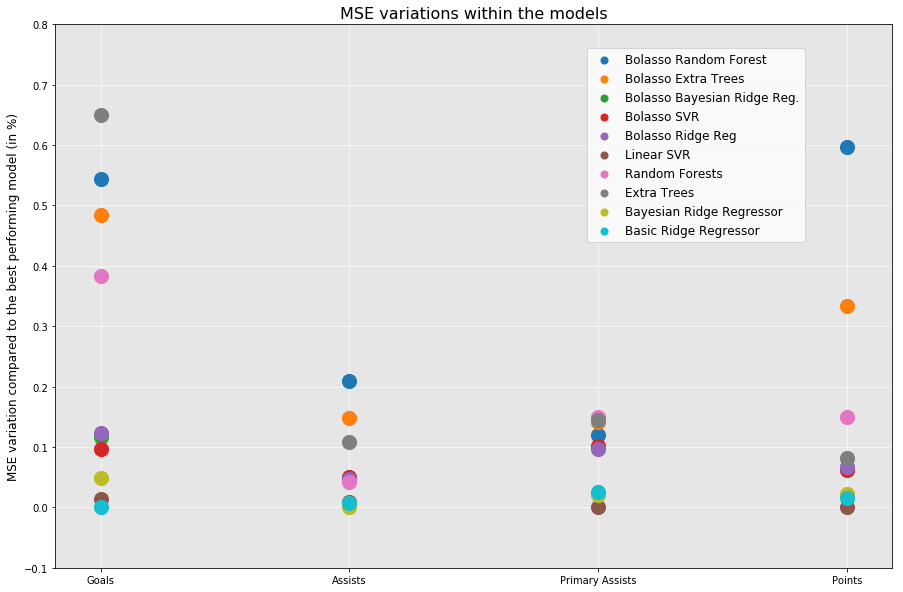

In [26]:
#Comparing the performance of models after variable selection


Bol_err=[Bol_Rf_err,Bol_Et_err,Bol_BR_err,Bol_SVR_err,Bol_BaseR_err]
cozy=[]

labels_Bol=['Bolasso Random Forest','Bolasso Extra Trees','Bolasso Bayesian Ridge Reg.','Bolasso SVR','Bolasso Ridge Reg']
labels_full=["Linear SVR",'Random Forests',"Extra Trees",'Bayesian Ridge Regressor','Basic Ridge Regressor']

for dots in sq_Err:
    cozy.append(dots[:3]+dots[-1:])

gfd = np.array(Bol_err+cozy).min(axis=0)
#print(gfd)


fig1=plt.figure('tadam',figsize=(15,10))
ax = fig1.add_subplot(1, 1, 1)
ax.set_axisbelow(True)
ax.set_ylim(ymin=-0.1, ymax=0.8)
plt.ylabel('MSE variation compared to the best performing model (in %)',fontsize=12)
plt.title('MSE variations within the models',fontsize=16)

plt.grid(color='w', linestyle='solid',alpha=0.8)

for dots,lab in zip(Bol_err,labels_Bol):
    plt.scatter(range(4),(np.array(dots)-gfd)/gfd,label=lab,s=200)
    
for dots,lab in zip(cozy,labels_full):
    plt.scatter(range(4),(np.array(dots)-gfd)/gfd,label=lab,s=200)

ax.set_facecolor('#E6E6E6')

plt.xticks(list(range(4)),['Goals','Assists','Primary Assists','Points'])
lgnd=plt.legend(loc=(0.635,0.6),scatterpoints=1, fontsize=12)
for i in range(10):
    lgnd.legendHandles[i]._sizes = [50]

plt.savefig('MSE_Variations.jpg',quality=100,format='jpg')
plt.show()

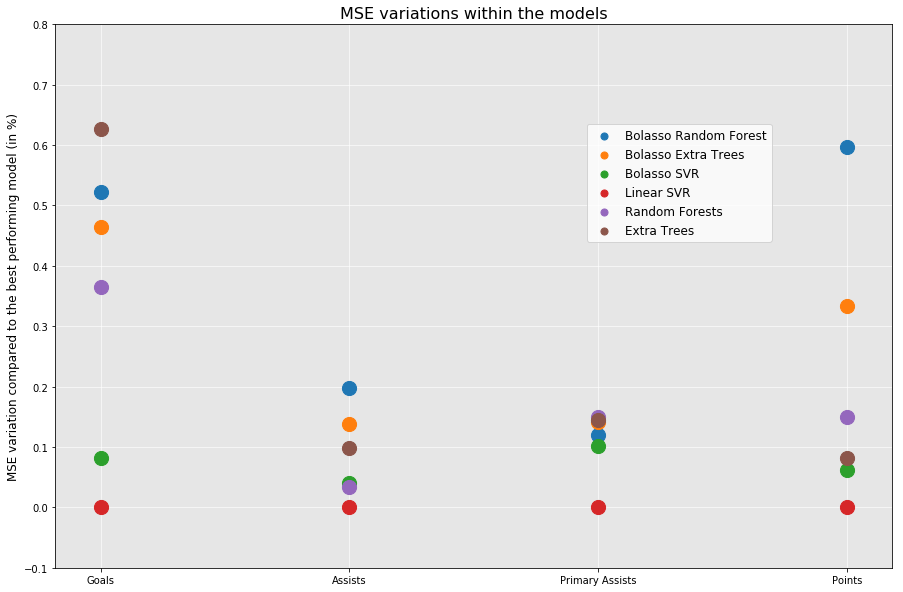

In [28]:
#Comparing the performance of models after variable selection
#Same as before, but without the ridge model


Bol_err=[Bol_Rf_err,Bol_Et_err,Bol_SVR_err,]
cozy=[]

labels_Bol=['Bolasso Random Forest','Bolasso Extra Trees','Bolasso SVR']
labels_full=["Linear SVR",'Random Forests',"Extra Trees",]

for dots in sq_Err[:3]:
    cozy.append(dots[:3]+dots[-1:])

gfd = np.array(Bol_err+cozy).min(axis=0)
#print(gfd)


fig1=plt.figure('tadam',figsize=(15,10))
ax = fig1.add_subplot(1, 1, 1)
ax.set_axisbelow(True)
ax.set_ylim(ymin=-0.1, ymax=0.8)
plt.ylabel('MSE variation compared to the best performing model (in %)',fontsize=12)
plt.title('MSE variations within the models',fontsize=16)

plt.grid(color='w', linestyle='solid',alpha=0.8)

for dots,lab in zip(Bol_err,labels_Bol):
    plt.scatter(range(4),(np.array(dots)-gfd)/gfd,label=lab,s=200)
    
for dots,lab in zip(cozy,labels_full):
    plt.scatter(range(4),(np.array(dots)-gfd)/gfd,label=lab,s=200)

ax.set_facecolor('#E6E6E6')

plt.xticks(list(range(4)),['Goals','Assists','Primary Assists','Points'])
lgnd=plt.legend(loc=(0.635,0.6),scatterpoints=1, fontsize=12)
for i in range(6):
    lgnd.legendHandles[i]._sizes = [50]

plt.savefig('MSE_Variations.jpg',quality=100,format='jpg')
plt.show()
